In [1]:
import glob
import math
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

sys.path.append('..')

from cnsproject.filtering.filters import dog_filter, gabor_filter, conv2d
from cnsproject.encoding.encoders import Time2FirstSpikeEncoder, PoissonEncoder
from cnsproject.utils import relu_normalize

mpl.rc('image', cmap='gray')

%matplotlib inline

# Introduction

In this project, we implement `DoG` and `Gabor` filters and use different
filter parameter sets and convolve them on two images, then we clip the negative
values of convolution's output. Finally, we encode the output of previous steps
using `Time2FirstSpike` and Poisson `Encoders`.

In [98]:
pi = math.pi


def draw_dog_plots(image, f_size, sig1s, sig2s):
    num_ax = 7
    fig, axs = plt.subplots(len(sig1s), num_ax, figsize=(num_ax * 2, 4))
    j = 0
    for sig1, sig2 in zip(sig1s, sig2s):
        ax = axs[j]
        j += 1
        off_center = False
        dog = dog_filter(f_size, sig1, sig2, is_off_center=off_center)
        dog_filtered = conv2d(image, dog, padding="valid", strides=(1, 1))
        ax[0].imshow(image)
        ax[0].title.set_text('input')
        ax[1].imshow(dog)
        ax[1].title.set_text(f'$\sigma_1={sig1}$, $\sigma_2={sig2}$')
        ax[2].imshow(dog_filtered)
        ax[2].title.set_text('out (on-center)')
        ax[3].imshow(relu_normalize(dog_filtered))
        ax[3].title.set_text('clipped (on-center)')
        off_center = True
        dog = dog_filter(f_size, sig1, sig2, is_off_center=off_center)
        dog_filtered = conv2d(image, dog, padding="valid", strides=(1, 1))
        ax[4].imshow(dog)
        ax[4].title.set_text(f'$\sigma_1={sig1}$, $\sigma_2={sig2}$')
        ax[5].imshow(dog_filtered)
        ax[5].title.set_text('out (off-center)')
        ax[6].imshow(relu_normalize(dog_filtered))
        ax[6].title.set_text('clipped (off-center)')

        for i in range(len(ax)):
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    fig.tight_layout()
    plt.show()


def draw_gabor_plots(image, f_size, params):
    num_ax = 7
    fig, axs = plt.subplots(len(params), num_ax,
                            figsize=(num_ax * 2, len(params) * 2))
    for j, param in enumerate(params):
        ax = axs[j]
        sig = param[0]
        gamma = param[1]
        lam = param[2]
        theta = param[3]
        off = False
        gabor = gabor_filter(f_size, sig, gamma, lam, theta, is_off_center=off)
        gabor_filtered = conv2d(image, gabor, padding="valid",
                                strides=(1, 1))
        ax[0].imshow(image)
        ax[0].title.set_text('input')
        ax[1].imshow(gabor)
        ax[1].title.set_text(
            r'$\sigma={:.2f}, \gamma={:.1f}$'.format(sig, gamma)
        )
        ax[2].imshow(gabor_filtered)
        ax[2].title.set_text('out (on-center)')
        ax[3].imshow(relu_normalize(gabor_filtered))
        ax[3].title.set_text('clipped (on-center)')
        off = True
        gabor = gabor_filter(f_size, sig, gamma, lam, theta, is_off_center=off)
        gabor_filtered = conv2d(image, gabor, padding="valid",
                                strides=(1, 1))
        ax[4].imshow(gabor)
        ax[4].title.set_text(
            r'$\lambda={:.1f}\pi, \theta={}^{{\circ}}$'.format(lam / pi,
                                                               theta)
        )
        ax[5].imshow(gabor_filtered)
        ax[5].title.set_text('out (off-center)')
        ax[6].imshow(relu_normalize(gabor_filtered))
        ax[6].title.set_text('clipped (off-center)')

        for i in range(len(ax)):
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    fig.tight_layout()
    plt.show()


In [3]:
image_paths = sorted(glob.glob('images/*'))
images = []
for path in image_paths:
    image = plt.imread(path)
    if len(image.shape) == 3:
        image_gray = image.mean(axis=2)
    else:
        image_gray = image
    image_gray = cv2.resize(image_gray, (150, 150))
    image_gray = image_gray.astype(float) / 255
    images.append(image_gray)

# Part 1

## DoG Filter

We use two different filter sizes: $5$ and $13$.

### $FilterSize = 5$

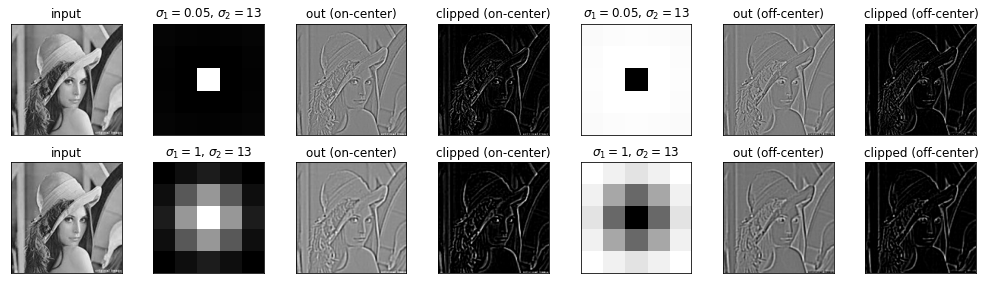

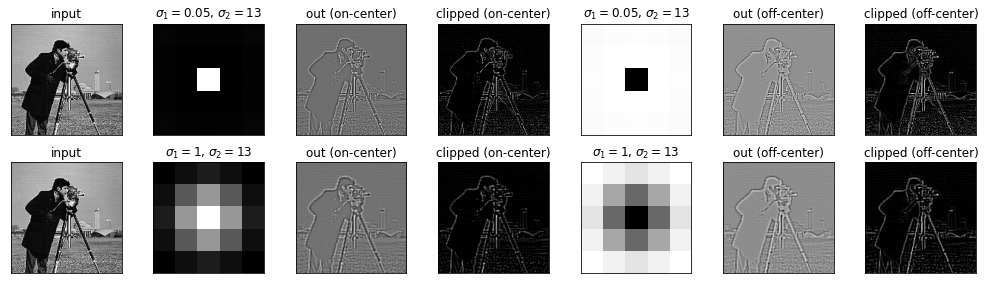

In [4]:
draw_dog_plots(images[1], 5, [0.05, 1], [13, 13])
draw_dog_plots(images[0], 5, [0.05, 1], [13, 13])

### $FilterSize = 15$

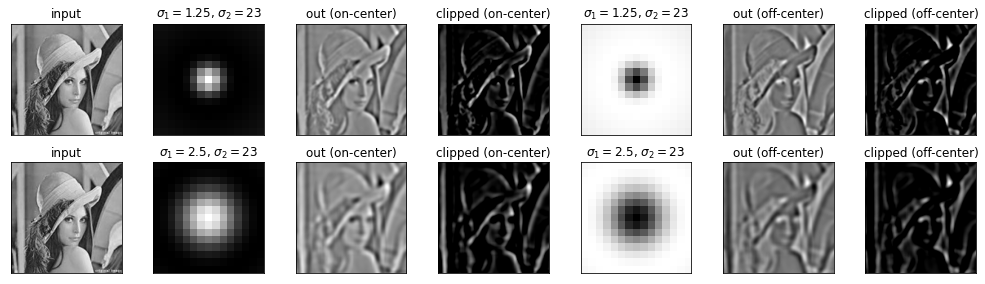

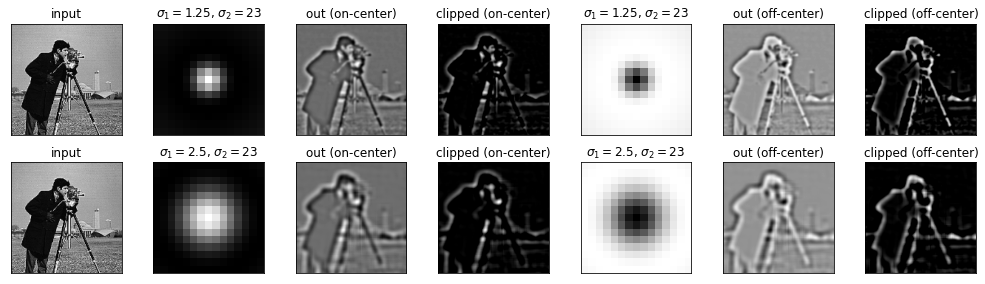

In [5]:
draw_dog_plots(images[1], 15, [1.25, 2.5], [23, 23])
draw_dog_plots(images[0], 15, [1.25, 2.5], [23, 23])

## Gabor Filter

### $FilterSize=7$

#### $\sigma$ Effect

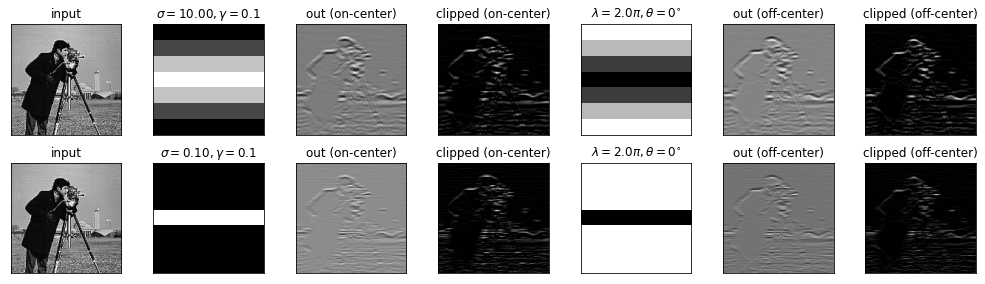

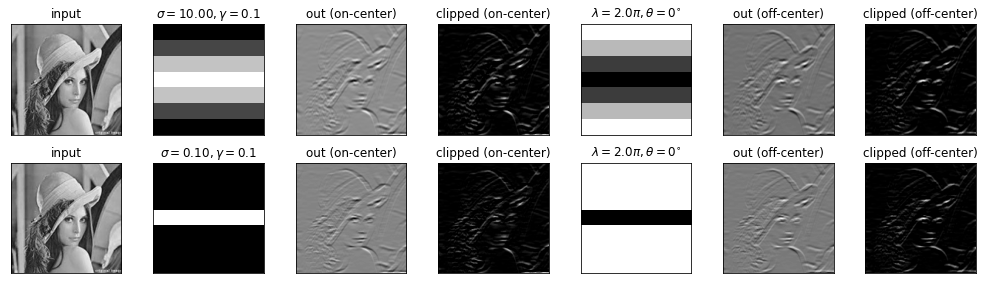

In [88]:
params = [
    (10, 0.1, 2 * pi, 0),
    (0.1, 0.1, 2 * pi, 0),
]
draw_gabor_plots(images[0], 7, params=params)
draw_gabor_plots(images[1], 7, params=params)



### $FilterSize=15$

#### $\theta$ Effect

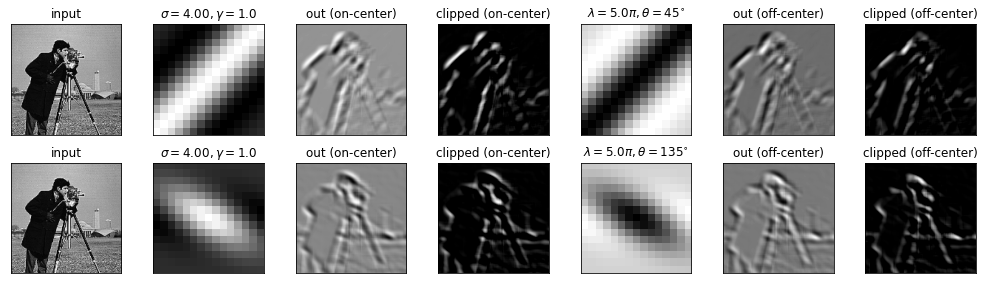

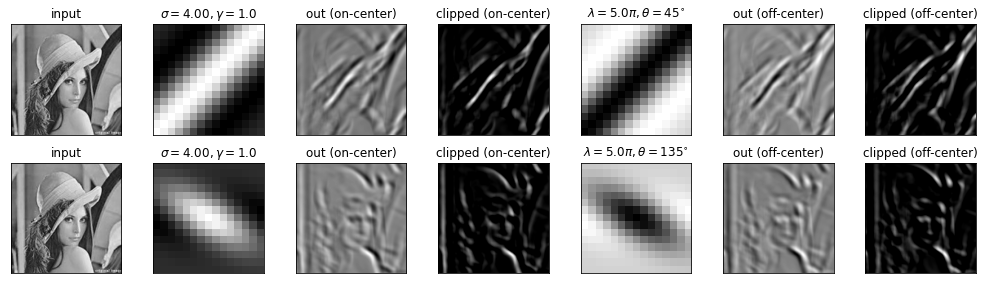

In [90]:
params = [
    (4, 1, 5 * pi, 45),
    (4, 1, 5 * pi, 135),
]
draw_gabor_plots(images[0], 15, params=params)
draw_gabor_plots(images[1], 15, params=params)

#### $\gamma$ Effect

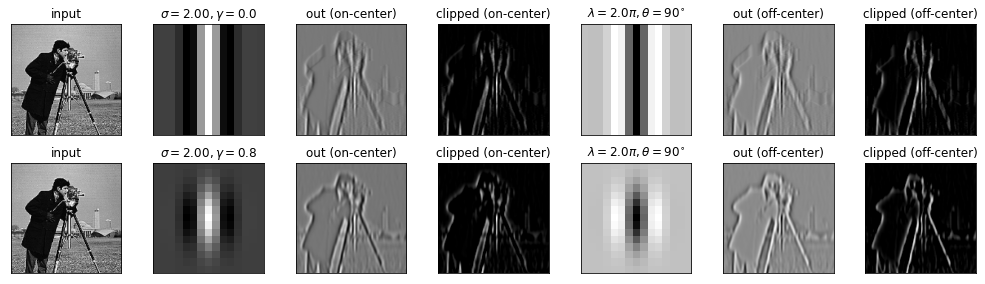

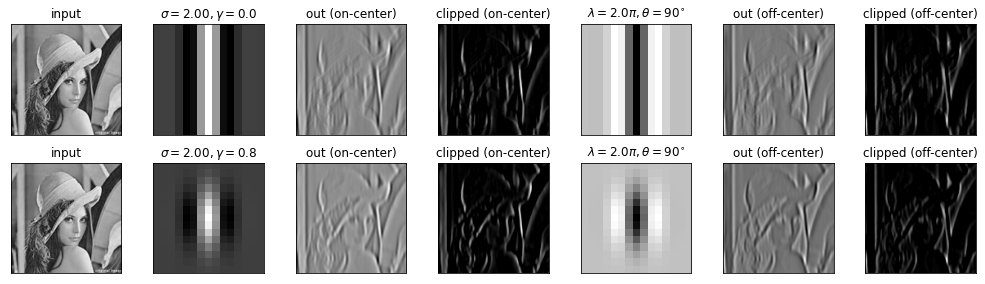

In [100]:
params = [
    (2, 0.01, 2 * pi, 90),
    (2, 0.75, 2 * pi, 90),
]
draw_gabor_plots(images[0], 15, params=params)
draw_gabor_plots(images[1], 15, params=params)

#### $\lambda$ Effect

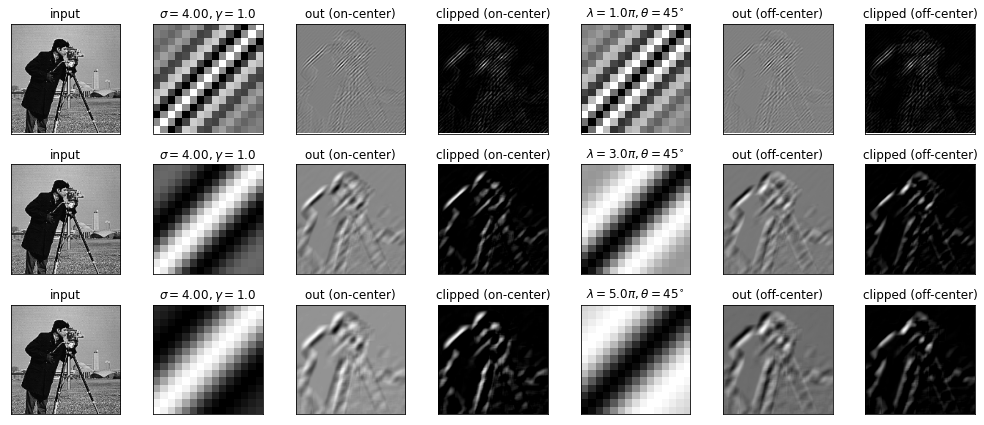

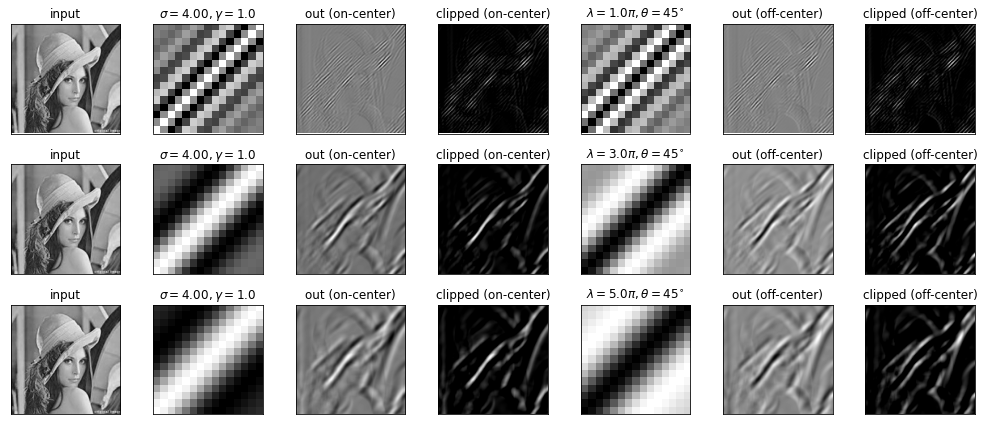

In [99]:
params = [
    (4, 1, 1 * pi, 45),
    (4, 1, 3 * pi, 45),
    (4, 1, 5 * pi, 45),
]
draw_gabor_plots(images[0], 15, params=params)
draw_gabor_plots(images[1], 15, params=params)

# Part 2

In this section we draw encoding (using `Time2FirstSpike` and `Poisson`)
outputs of the clipped feature maps.

Parameters of encoders:

**Time2FirstSpike**:
$Encoding Time: 10ms$

**PoissonEncoder**:
$Encoding Time: 10ms$, $RateMax=25$

**Note**: The $RateMax=25$ is selected for `PoissonEncoder` to make the
output of the encoder more visible. If we set $RateMax=EncodingTime$, the
sum of outputs in all time-steps will be almost the same as the input.

In [102]:
def draw_encoding_outputs(image, kernel, title=None, conv_strides=(1, 1)):
    fig, axs = plt.subplots(2, 7, figsize=(12, 4.5))
    kernel_copy = kernel.copy()
    t2fs_encoder = Time2FirstSpikeEncoder(10, data_max_val=1.)
    poisson_encoder = PoissonEncoder(10, rate_max=25,
                                     data_max_val=1.)
    for j in range(len(axs)):
        if j == 1:
            kernel_copy *= -1

        conv_out = conv2d(image, kernel_copy, 'valid', strides=conv_strides)
        clipped = relu_normalize(conv_out)
        t2fs_encoded = t2fs_encoder(clipped)
        poisson_encoded = poisson_encoder(clipped)

        ax = axs[j]
        for i in range(len(ax)):
            ax[i].set_yticks([])
            ax[i].set_xticks([])
        ax[0].imshow(image)
        ax[1].imshow(kernel_copy)
        ax[2].imshow(clipped)
        ax[3].imshow(t2fs_encoded[3])
        ax[4].imshow(t2fs_encoded[6])
        ax[5].imshow(t2fs_encoded[:8].sum(dim=0))
        ax[6].imshow(poisson_encoded.sum(dim=0))
        ax[0].title.set_text(f'input {image.shape}')
        if j == 0:
            ax[1].title.set_text('filter on-center')
        if j == 1:
            ax[1].title.set_text('filter off-center')
        ax[2].title.set_text('clipped conv output')
        ax[3].title.set_text('T2FS 4th ms')
        ax[4].title.set_text('T2FS 7th ms')
        ax[5].title.set_text('T2FS[:8] sum')
        ax[6].title.set_text(
            f'Poisson-sum={int(poisson_encoded.sum().item())}')

    if title is not None:
        fig.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()


def create_dog_kernels(params):
    kernels = []
    for param in params:
        f_size = param[0]
        sig1 = param[1]
        sig2 = param[2]
        kernel = dog_filter(f_size, sig1, sig2)
        kernels.append(kernel)
    return kernels


def create_gabor_kernels(params):
    kernels = []
    for param in params:
        f_size = param[0]
        sig = param[1]
        gamma = param[2]
        lam = param[3]
        theta = param[4]
        kernel = gabor_filter(f_size, sig, gamma, lam, theta)
        kernels.append(kernel)
    return kernels


def draw_plots_with_title(params, s=(1, 1)):
    gabor_kernels = create_gabor_kernels(params)
    for kernel, param in zip(gabor_kernels, params):
        f_size = param[0]
        sig = param[1]
        gamma = param[2]
        lam = int(param[3] / pi)
        theta = param[4]
        title = r'$FS={}$, $\sigma={}$, $\gamma={}$, $\lambda={}\pi$, $\theta={}^{{\circ}}$'.format(
            f_size, sig, gamma, lam, theta
        )
        draw_encoding_outputs(images[0], kernel, title=title, conv_strides=s)
        draw_encoding_outputs(images[1], kernel, conv_strides=s)


## DoG Filters

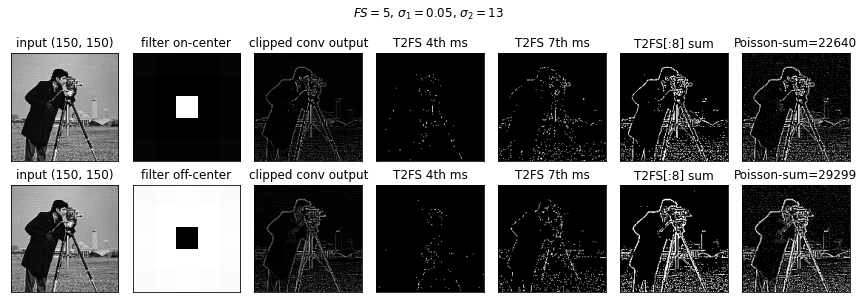

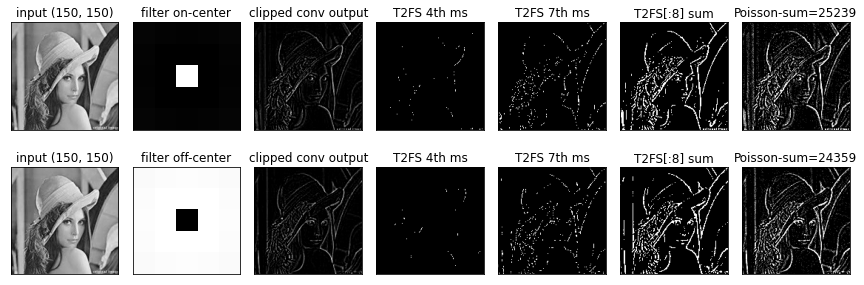

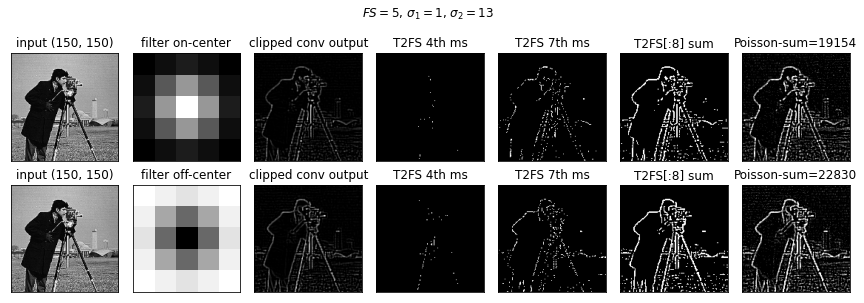

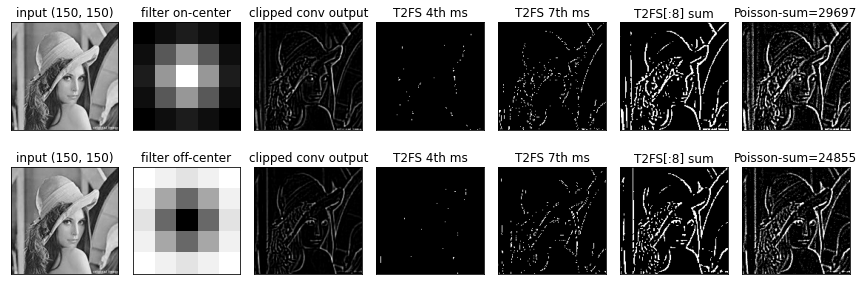

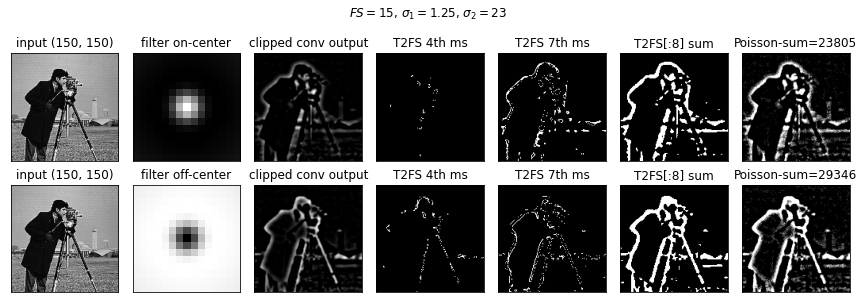

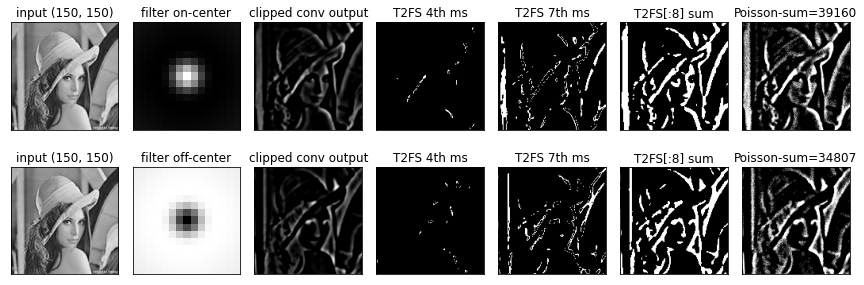

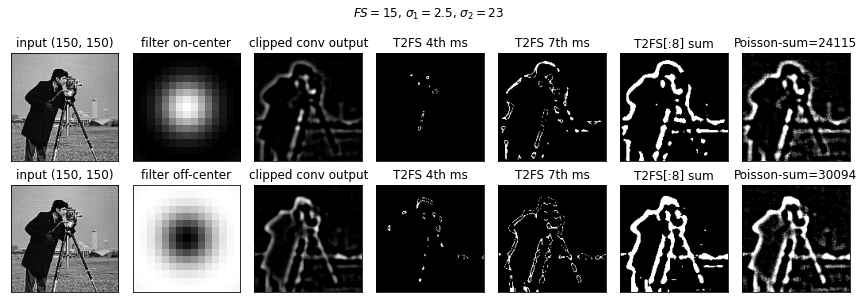

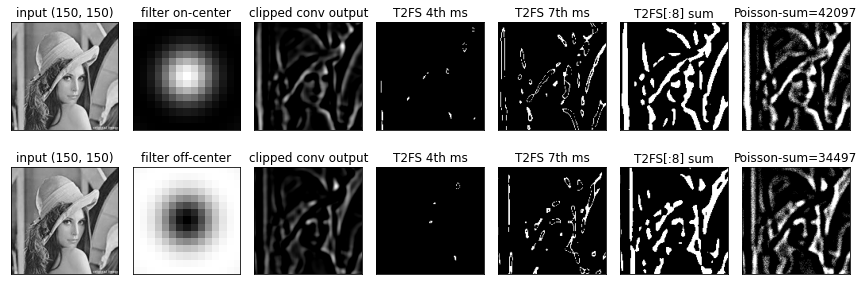

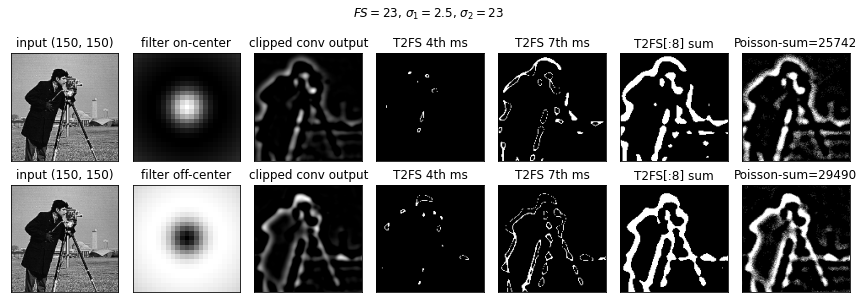

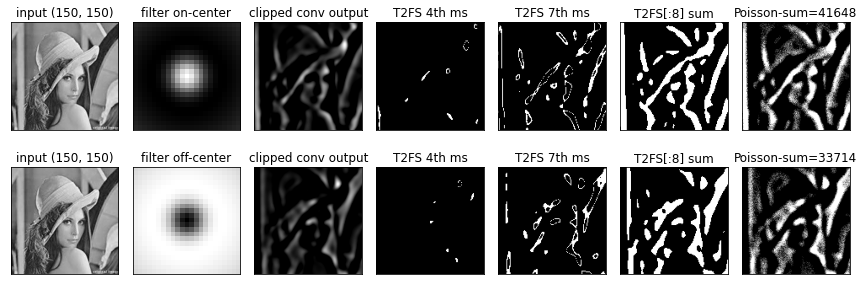

In [11]:
params = [
    (5, 0.05, 13),
    (5, 1, 13),
    (15, 1.25, 23),
    (15, 2.5, 23),
    (23, 2.5, 23)
]
dog_kernels = create_dog_kernels(params)

for kernel, param in zip(dog_kernels, params):
    f_size = param[0]
    sig1 = param[1]
    sig2 = param[2]
    title = "$FS={}$, $\sigma_1={}$, $\sigma_2={}$".format(f_size, sig1, sig2)
    draw_encoding_outputs(images[0], kernel, title=title)
    draw_encoding_outputs(images[1], kernel)


From the above figures, we can conclude that Time2FirstSpike encoder is encoding
the parts of the images where it is more similar to the filter earlier, and
the parts where is less similar to the filter in the later time-steps. The parts
of the image that is not similar to the filter will be encoded in the
last time-steps, and they contain no useful information. If we sum the
output of T2FS through time until the 8th time-step, we see that the actual
input (the clipped output of convolution) is being created. In Poisson encoder,
all the information is present in all time steps, but the intensity is low.
If we sum the outputs of the Poisson Encoder in all time-steps, we see
that the input is being created. Compared to the T2FS encoder, Poisson encoder's
output contains slightly more details which might not be very useful for tasks
like classification.

## Gabor Filters

### Effect of $\sigma$

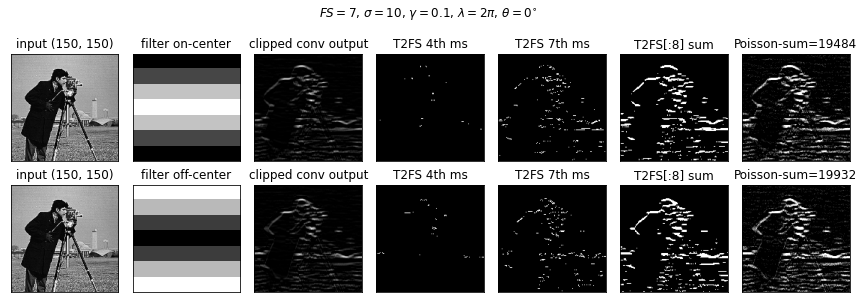

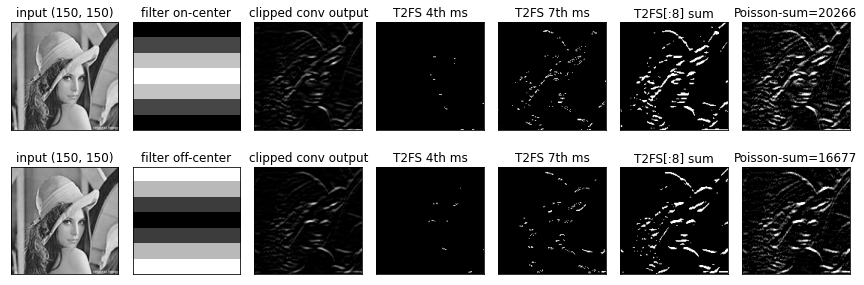

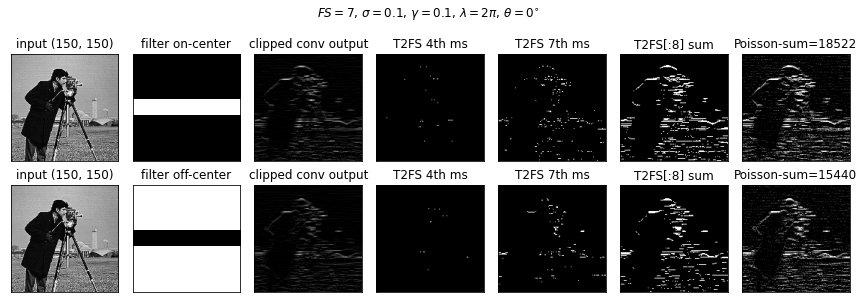

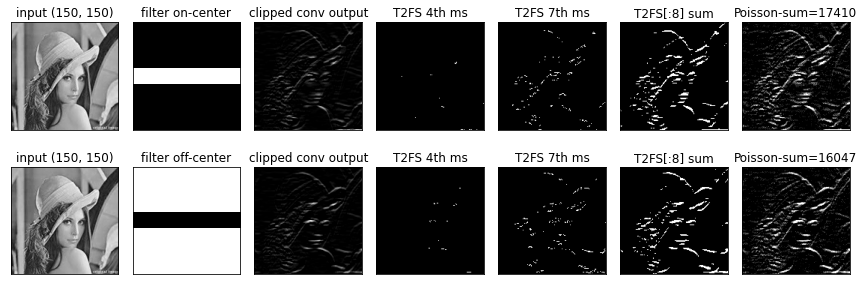

In [48]:
params = [
    (7, 10, 0.1, 2 * pi, 0),
    (7, 0.1, 0.1, 2 * pi, 0),
]

draw_plots_with_title(params)

In the above plots, we see the effect of $\sigma$. Higher sigma indicates smoother
changes in the filter. Since in real images the lines are not as sharp as what
you see in the second filter, the output of the first filter has more spikes
as shown in poisson encoder output. Also, none of the images have very intense
horizontal lines, so we do not see many spikes in T2FS encoder output in
the early time steps.


### Effect of $\theta$

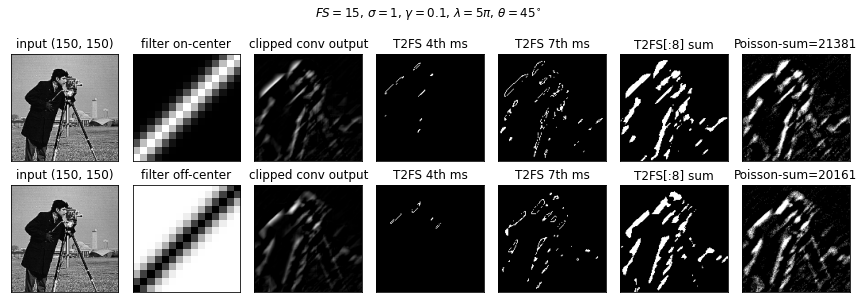

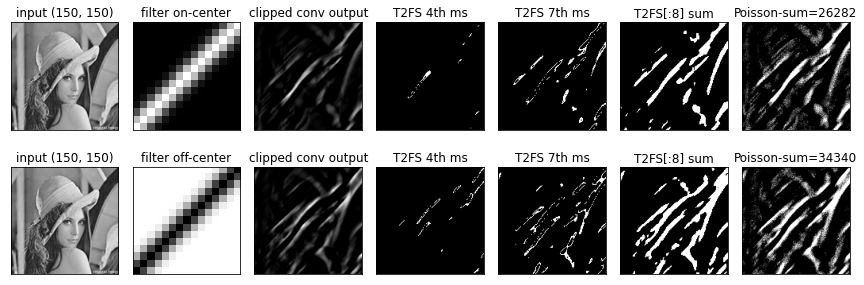

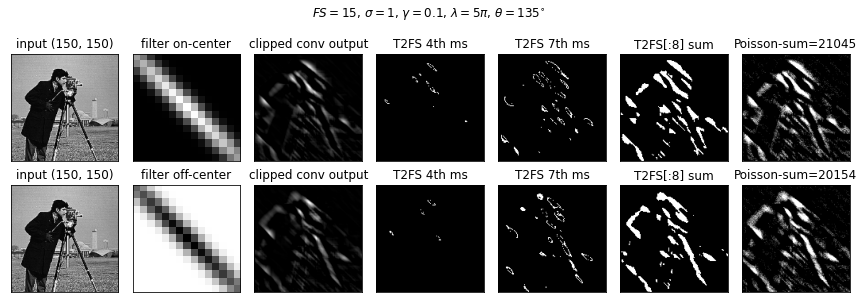

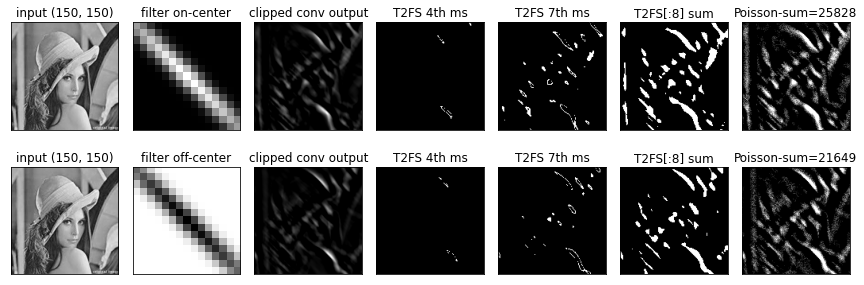

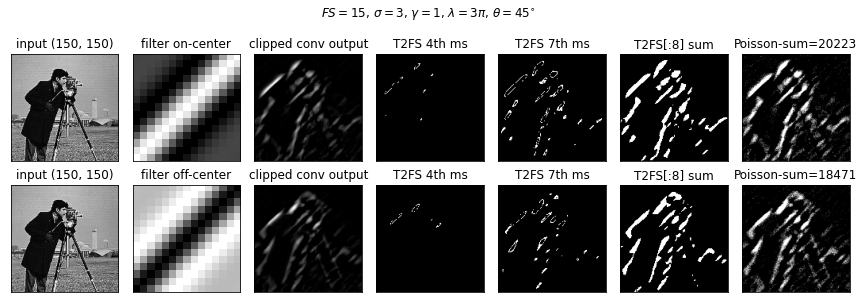

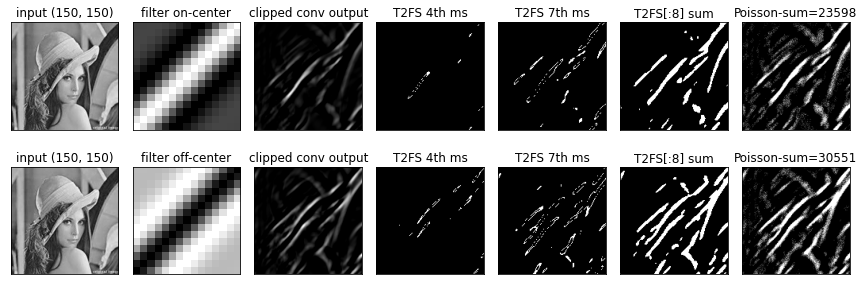

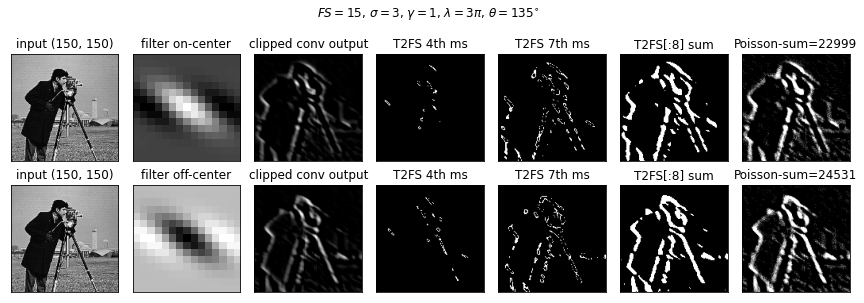

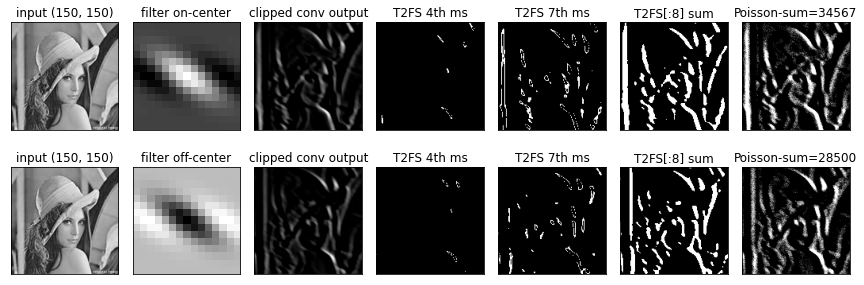

In [66]:
params = [
    (15, 1, 0.1, 5 * pi, 45),
    (15, 1, 0.1, 5 * pi, 135),
    (15, 3, 1, 3 * pi, 45),
    (15, 3, 1, 3 * pi, 135),
]

draw_plots_with_title(params)

When we use a $135^{\circ}$ filter on the woman image, we see a low amount
of spikes in the early time-steps of T2FS encoder. The reason is that the
there are not great matches for that filter in the image.

### Effect of $\gamma$

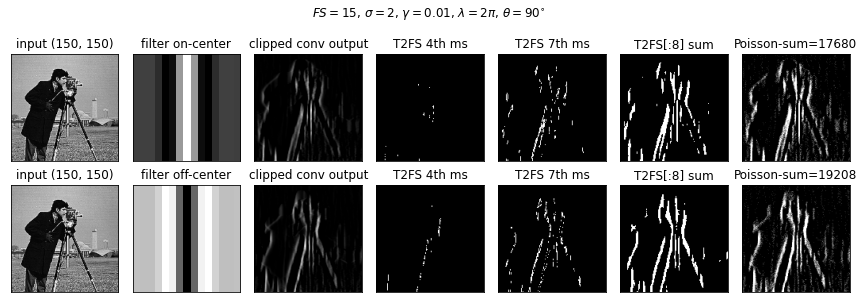

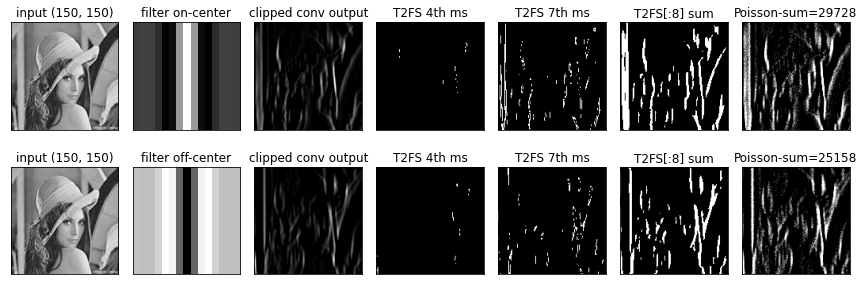

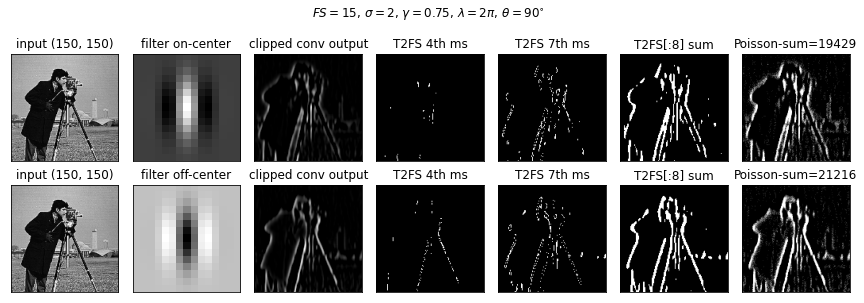

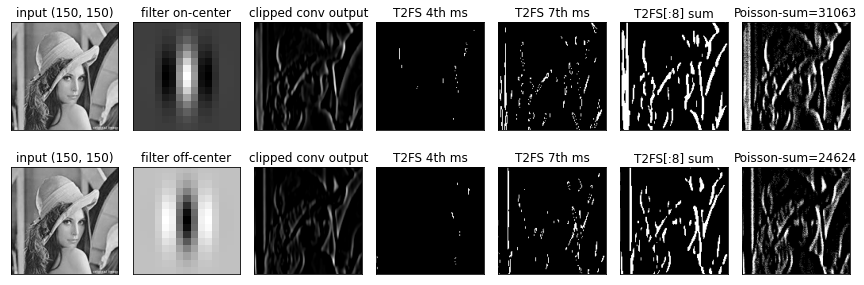

In [87]:
params = [
    (15, 2, 0.01, 2 * pi, 90),
    (15, 2, 0.75, 2 * pi, 90),
]

draw_plots_with_title(params)

### Effect of $\lambda$

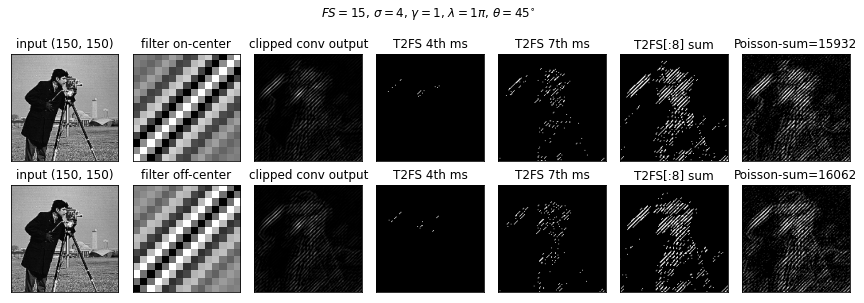

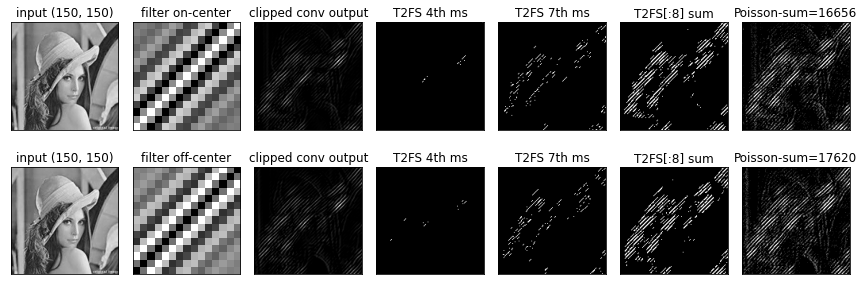

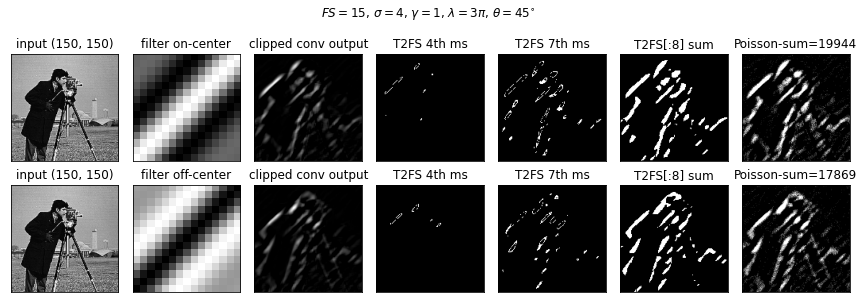

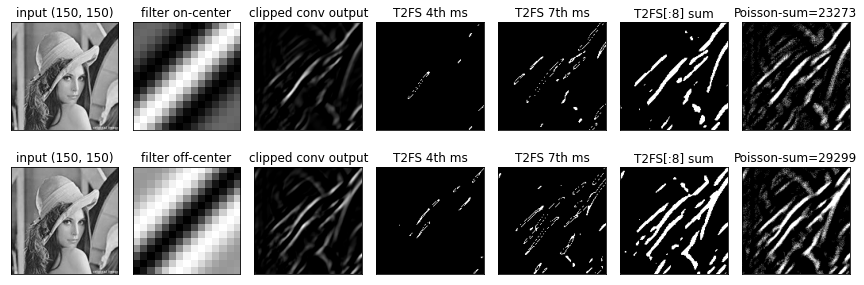

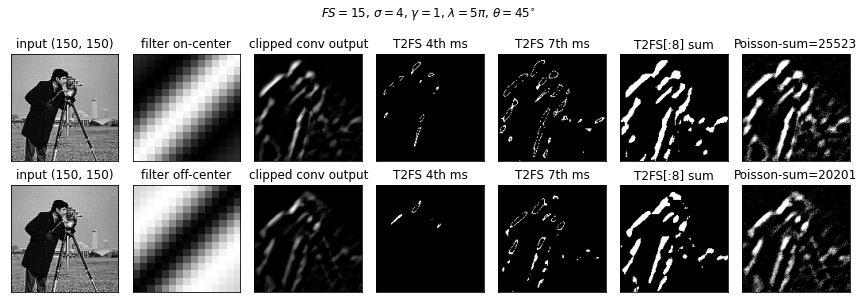

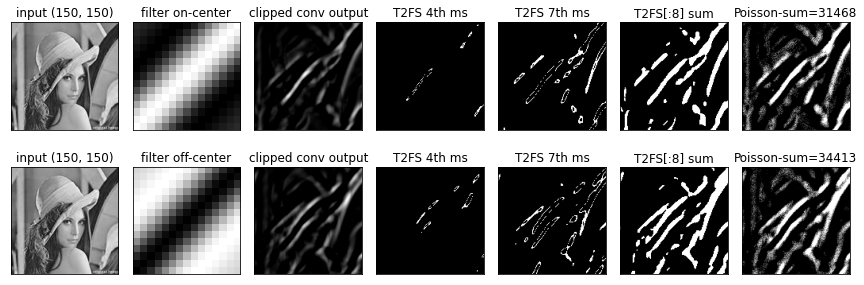

In [85]:
params = [
    (15, 4, 1, 1 * pi, 45),
    (15, 4, 1, 3 * pi, 45),
    (15, 4, 1, 5 * pi, 45),
]

draw_plots_with_title(params)

## Effect of Convolution Stride

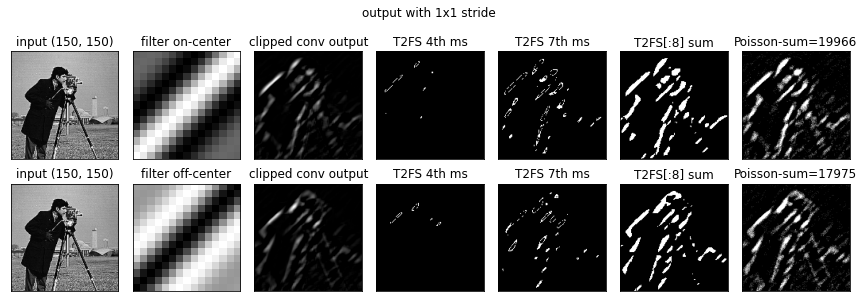

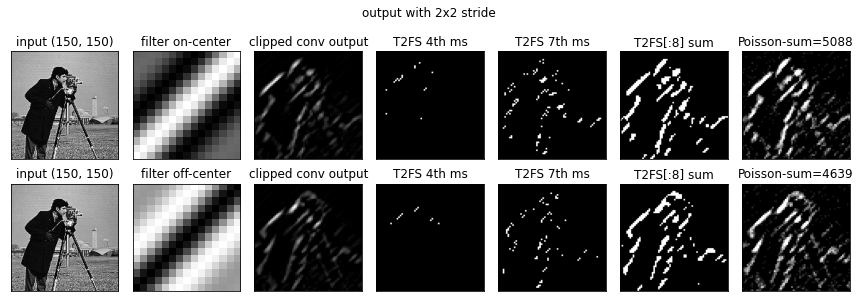

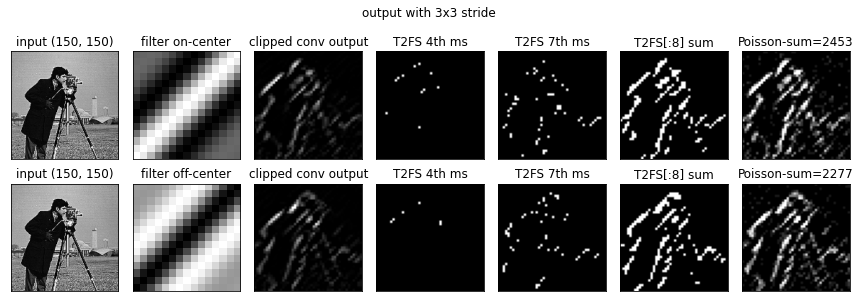

In [108]:

kernel = gabor_filter(15, 4, 1, 3 * pi, 45)
title = "output with 1x1 stride"
draw_encoding_outputs(images[0], kernel, title=title, conv_strides=(1, 1))
title = "output with 2x2 stride"
draw_encoding_outputs(images[0], kernel, title=title, conv_strides=(2, 2))
title = "output with 3x3 stride"
draw_encoding_outputs(images[0], kernel, title=title, conv_strides=(3, 3))

By applying different strides, we see that the output's pattern is not changing
significantly. By increasing the strides, some sort of down-sampling is
taking place, so output's shape is reduced. Only some unimportant details
will be lost by increasing stride.

# Summary

1. By using filters with larger size, we are increasing receptive field and
patterns (dots and lines) with larger size will be found in images. If we increase the filter size
too much, the output will not be informative.
2. Both encoders tend to encode the image through time and if we sum the encoding
outputs through time we will get the encoding input.
3. `Time2FirstSpike` encoder encodes parts of the image
where its more similar to the filter in earlier time steps and parts with less
similarity in later time-steps. Parts of the image that are not alike the filter
will be encoded in the last time steps, so they can be ignored completely.
The reason for this behaviour is the fact that parts of image with more
similarity to the filter will have more intensity in the filtering output and
`T2FS` encoder will encode pixels with more intensities in earlier time-steps.
4. `Poisson` encoder encodes the filtering output in all time steps almost
equally, but it is a bit noisy in each time-step. By summing encoding output
 in all time-steps, the noise's effect will be diminished, and we can see
 the input clearly in the encoding output.
5. Total number of spikes using Poisson encoder depends on two factors:
    * Input size: larger input size will produce more spikes
    * Similarity of the filter with the input image:
    If the input image is similar to the filter, the output of convolution
    contains pixels with more intensity. This high intensity increases the number
    of spikes in the encoding output.
5. By increasing the strides, the output of the encoding will be affected
significantly as long as the input size is big enough. Convolving with strides
larger than 1, downsamples the input.

